<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing-Tutorial/blob/main/FCLSU_VCA_APEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Unmixing

Supervised unmixing baseline using VCA for endmembers extraction and FCLSU for abundances estimation.

---

## Imports

In [36]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import time
import os

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
from cvxopt import matrix, solvers

from munkres import Munkres

## Data

---

Download datasets archive and unzip them in the main directory.

In [18]:
!wget http://pascal.inrialpes.fr/data2/azouaoui/data.zip && unzip data.zip

--2022-09-20 08:43:34--  http://pascal.inrialpes.fr/data2/azouaoui/data.zip
Resolving pascal.inrialpes.fr (pascal.inrialpes.fr)... 194.199.16.17
Connecting to pascal.inrialpes.fr (pascal.inrialpes.fr)|194.199.16.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126901951 (121M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 121.02M  10.3MB/s    in 17s     

2022-09-20 08:43:52 (7.20 MB/s) - ‘data.zip’ saved [126901951/126901951]

Archive:  data.zip
  inflating: JasperRidge.mat         
  inflating: Samson.mat              
  inflating: TinyAPEX.mat            
  inflating: Urban4.mat              
  inflating: Urban5.mat              
  inflating: Urban6.mat              
  inflating: WDC.mat                 


Create HSI data base object.

In [31]:
# Global constant
EPS = 1e-6

class HSI:
    def __init__(
        self,
        name: str,
        figs_dir: str = "./figs",
    ):
        assert os.path.isfile(name)
        self.shortname = name.strip(".mat")

        data = sio.loadmat(name)
        print(f"Matlab data keys: {data.keys()}")

        for key in filter(
            lambda k: not k.startswith("__"),
            data.keys(),
        ):
            self.__setattr__(key, data[key])

        # Data format check
        self.H = self.H.item()
        self.W = self.W.item()
        self.L = self.L.item()
        self.p = self.p.item()

        self.N = self.H * self.W

        print(self.Y.shape)
        assert self.E.shape == (self.L, self.p)
        assert self.Y.shape == (self.L, self.N)

        # Data normalization
        self.Y = (self.Y - self.Y.min()) / (self.Y.max() - self.Y.min())

        try:
            assert len(self.labels) == self.p
            # Curate labels from MATLAB string formatting
            tmp_labels = list(self.labels)
            self.labels = [s.strip(" ") for s in tmp_labels]

        except AssertionError:
            # Create pseudo labels
            self.labels = [f"#{ii}" for ii in range(self.p)]

        assert self.A.shape == (self.p, self.N)
        # Abundance Sum to One Constraint (ASC)
        assert np.allclose(self.A.sum(0), np.ones(self.N))
        # Abundance Non-negative Constraint (ANC)
        assert np.all(self.A >= -EPS)
        # Endmembers Non-negative Constraint
        self.E = np.maximum(self.E, 0)
        assert np.all(self.E >= -EPS)

        # Save figures path
        self.figs_dir = figs_dir
        if self.figs_dir is not None:
            os.makedirs(self.figs_dir, exist_ok=True)

    def __repr__(self):
        msg = f"HSI => {self.shortname}\n"
        msg += "---------------------\n"
        msg += f"{self.L} bands,\n"
        msg += f"{self.H} lines, {self.W} samples, ({self.N} pixels),\n"
        msg += f"{self.p} endmembers ({self.labels})\n"
        msg += f"GlobalMinValue: {self.Y.min()}, GlobalMaxValue: {self.Y.max()}\n"
        sparsity = (self.A <= 0.01).sum() / self.A.size
        sparsity_printable = round(sparsity, 2)
        msg += f"Sparsity: {sparsity_printable}\n"
        return msg


    def __call__(self):
        Y = np.copy(self.Y)
        E = np.copy(self.E)
        A = np.copy(self.A)
        return (Y, E, A)


    def plot_endmembers(
        self,
        E0=None,
        normalize=False,
        display=False,
        run=0,
    ):
        """
        Display endmembers spectrum signature
        """
        title = f"{self.shortname}"
        ylabel = "Reflectance"
        xlabel = "# Bands"
        if E0 is None:
            E = np.copy(self.E)
            title += " GT Endmembers\n"
            linestyle = "-"
        else:
            assert self.E.shape == E0.shape
            E = np.copy(E0)
            title += " Estimated Endmembers\n"
            linestyle = "--"
        max_correl = np.max(np.corrcoef(E.T) - np.eye(self.p))
        title += f"MaxCorrCoef => {round(max_correl, 2)}"
        plt.figure(figsize=(6, 6))
        for pp in range(self.p):
            data = E[:, pp]
            plt.plot(data, label=self.labels[pp], linestyle=linestyle)
        plt.title(title)
        plt.legend(frameon=True)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if display:
            plt.show()
        else:
            figname = f"{self.shortname}-"
            figname += f"endmembers-{run}-"
            figname += "GT" if E0 is None else ""
            figname += ".png"
            plt.savefig(os.path.join(self.figs_dir, figname))
            plt.close()

    def plot_abundances(
        self,
        A0=None,
        grid=None,
        transpose=False,
        display=False,
        run=0,
    ):
        """
        Display abundances maps
        """
        if grid is None:
            nrows, ncols = (1, self.p)
        else:
            assert len(grid) == 2
            nrows, ncols = grid
            assert nrows * ncols >= self.p

        title = f"{self.shortname}"
        if A0 is None:
            A = np.copy(self.A)
            title += " GT Abundances"
        else:
            assert self.A.shape == A0.shape
            A = np.copy(A0)
            title += " Estimated Abundances"
        A = A.reshape(self.p, self.H, self.W)
        if transpose:
            A = A.transpose(0, 2, 1)

        fig, ax = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(12, 4 * nrows),
        )
        kk = 0
        for ii in range(nrows):
            for jj in range(ncols):
                if nrows == 1:
                    curr_ax = ax[jj]
                else:
                    curr_ax = ax[ii, jj]
                mappable = curr_ax.imshow(
                    A[kk, :, :],
                    vmin=0.0,
                    vmax=1.0,
                )
                curr_ax.set_title(f"{self.labels[kk]}")
                curr_ax.axis("off")
                fig.colorbar(
                    mappable,
                    ax=curr_ax,
                    shrink=0.5,
                )
                kk += 1

                if kk == self.p:
                    break

        plt.suptitle(title)
        if display:
            plt.show()
        else:
            figname = f"{self.shortname}-"
            figname += f"abundances-{run}-"
            figname += "GT" if A0 is None else ""
            figname += ".png"
            path = os.path.join(self.figs_dir, figname)
            plt.savefig(path)
            plt.close()




Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'])
(285, 13542)
HSI => TinyAPEX
---------------------
285 bands,
111 lines, 122 samples, (13542 pixels),
4 endmembers (['#0', '#1', '#2', '#3'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0
Sparsity: 0.47



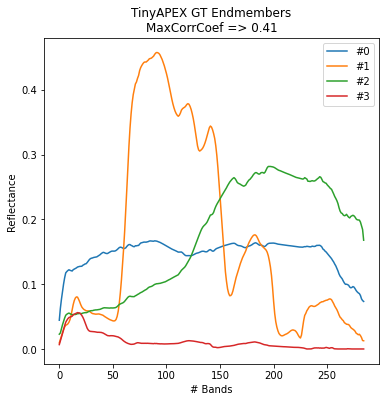

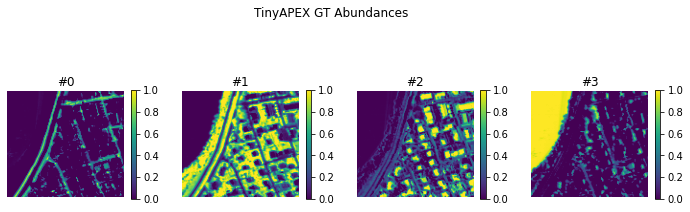

In [32]:
hsi = HSI("TinyAPEX.mat")
print(hsi)
hsi.plot_endmembers(display=True)
hsi.plot_abundances(display=True)

## Endmembers extraction

In [21]:
class BaseInit:
    def __init__(self):
        self.seed = None

    def init_like(self, hsi, seed=0):
        return NotImplementedError

    def __repr__(self):
        msg = f"{self.__class__.__name__}_seed{self.seed}"
        return msg


class TrueEndmembers(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, **kwargs):
        return hsi.E


class RandomPositiveMatrix(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, seed=0):
        self.seed = seed
        generator = np.random.RandomState(seed=self.seed)
        return generator.rand(hsi.L, hsi.p)


class RandomPixels(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, seed=0):
        self.seed = seed
        generator = np.random.RandomState(seed=self.seed)
        indices = generator.randint(0, high=hsi.N - 1, size=hsi.p)
        print(f"Indices randomly chosen: {indices}")
        pixels = hsi.Y[:, indices]
        assert pixels.shape == hsi.E.shape
        return pixels


class VCA(BaseInit):
    def __init__(self):
        super().__init__()

    def init_like(self, hsi, seed=0, snr_input=0):
        """
        Vertex Component Analysis
        ------- Input variables -------------
        HSI containing the following variables =>
         Y - matrix with dimensions L(channels) x N(pixels)
             each pixel is a linear mixture of R endmembers
             signatures Y = M x s, where s = gamma x alfa
             gamma is a illumination perturbation factor and
             alfa are the abundance fractions of each endmember.
         p - positive integer number of endmembers in the scene
        ------- Output variables -----------
        E     - estimated mixing matrix (endmembers signatures)
        ------- Optional parameters---------
        snr_input - (float) signal to noise ratio (dB)
        ------------------------------------
        Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
        This code is a translation of a matlab code provided by
        Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
        available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
        Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
        more details on:
        Jose M. P. Nascimento and Jose M. B. Dias
        "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
        submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
        """
        Y = hsi.Y
        N, p = hsi.N, hsi.p
        self.seed = seed
        generator = np.random.RandomState(seed=seed)

        #############################################
        # SNR Estimates
        #############################################

        if snr_input == 0:
            y_m = np.mean(Y, axis=1, keepdims=True)
            Y_o = Y - y_m  # data with zero-mean
            Ud = LA.svd(np.dot(Y_o, Y_o.T) / float(N))[0][
                :, :p
            ]  # computes the R-projection matrix
            x_p = np.dot(Ud.T, Y_o)  # project the zero-mean data onto p-subspace

            SNR = self.estimate_snr(Y, y_m, x_p)

            print(f"SNR estimated = {SNR:.2f}[dB]")
        else:
            SNR = snr_input
            print(f"input SNR = {SNR:.2f}[dB]\n")

        SNR_th = 15 + 10 * np.log10(p)
        #############################################
        # Choosing Projective Projection or
        #          projection to p-1 subspace
        #############################################

        if SNR < SNR_th:
            print("... Select proj. to R-1")

            d = p - 1
            if snr_input == 0:  # it means that the projection is already computed
                Ud = Ud[:, :d]
            else:
                y_m = np.mean(Y, axis=1, keepdims=True)
                Y_o = Y - y_m  # data with zero-mean

                Ud = LA.svd(np.dot(Y_o, Y_o.T) / float(N))[0][
                    :, :d
                ]  # computes the p-projection matrix
                x_p = np.dot(Ud.T, Y_o)  # project thezeros mean data onto p-subspace

            Yp = np.dot(Ud, x_p[:d, :]) + y_m  # again in dimension L

            x = x_p[:d, :]  #  x_p =  Ud.T * Y_o is on a R-dim subspace
            c = np.amax(np.sum(x ** 2, axis=0)) ** 0.5
            y = np.vstack((x, c * np.ones((1, N))))
        else:
            print("... Select the projective proj.")

            d = p
            Ud = LA.svd(np.dot(Y, Y.T) / float(N))[0][
                :, :d
            ]  # computes the p-projection matrix

            x_p = np.dot(Ud.T, Y)
            Yp = np.dot(
                Ud, x_p[:d, :]
            )  # again in dimension L (note that x_p has no null mean)

            x = np.dot(Ud.T, Y)
            u = np.mean(x, axis=1, keepdims=True)  # equivalent to  u = Ud.T * r_m
            y = x / np.dot(u.T, x)

        #############################################
        # VCA algorithm
        #############################################

        indices = np.zeros((p), dtype=int)
        A = np.zeros((p, p))
        A[-1, 0] = 1

        for i in range(p):
            w = generator.rand(p, 1)
            f = w - np.dot(A, np.dot(LA.pinv(A), w))
            f = f / np.linalg.norm(f)

            v = np.dot(f.T, y)

            indices[i] = np.argmax(np.absolute(v))
            A[:, i] = y[:, indices[i]]  # same as x(:,indice(i))

        E = Yp[:, indices]

        print(f"Indices chosen to be the most pure: {indices}")
        self.indices = indices

        return E

    @staticmethod
    def estimate_snr(Y, r_m, x):
        L, N = Y.shape  # L number of bands (channels), N number of pixels
        p, N = x.shape  # p number of endmembers (reduced dimension)

        P_y = np.sum(Y ** 2) / float(N)
        P_x = np.sum(x ** 2) / float(N) + np.sum(r_m ** 2)
        snr_est = 10 * np.log10((P_x - p / L * P_y) / (P_y - P_x))

        return snr_est

## Abundances estimation

In [22]:
class FCLSU:
    def __init__(self):
        pass

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

    @staticmethod
    def _numpy_None_vstack(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.vstack([A1, A2])

    @staticmethod
    def _numpy_None_concatenate(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.concatenate([A1, A2])

    @staticmethod
    def _numpy_to_cvxopt_matrix(A):
        A = np.array(A, dtype=np.float64)
        if A.ndim == 1:
            return matrix(A, (A.shape[0], 1), "d")
        else:
            return matrix(A, A.shape, "d")

    def solve(self, Y, E):
        """
        Performs fully constrained least squares of each pixel in M
        using the endmember signatures of U. Fully constrained least squares
        is least squares with the abundance sum-to-one constraint (ASC) and the
        abundance nonnegative constraint (ANC).
        Parameters:
            Y: `numpy array`
                2D data matrix (L x N).
            E: `numpy array`
                2D matrix of endmembers (L x p).
        Returns:
            X: `numpy array`
                2D abundance maps (p x N).
        References:
            Daniel Heinz, Chein-I Chang, and Mark L.G. Fully Constrained
            Least-Squares Based Linear Unmixing. Althouse. IEEE. 1999.
        Notes:
            Three sources have been useful to build the algorithm:
                * The function hyperFclsMatlab, part of the Matlab Hyperspectral
                Toolbox of Isaac Gerg.
                * The Matlab (tm) help on lsqlin.
                * And the Python implementation of lsqlin by Valera Vishnevskiy, click:
                http://maggotroot.blogspot.ca/2013/11/constrained-linear-least-squares-in.html
                , it's great code.
        """
        tic = time.time()
        assert len(Y.shape) == 2
        assert len(E.shape) == 2

        L1, N = Y.shape
        L2, p = E.shape

        assert L1 == L2

        # Reshape to match implementation
        M = np.copy(Y.T)
        U = np.copy(E.T)

        solvers.options["show_progress"] = False

        U = U.astype(np.double)

        C = self._numpy_to_cvxopt_matrix(U.T)
        Q = C.T * C

        lb_A = -np.eye(p)
        lb = np.repeat(0, p)
        A = self._numpy_None_vstack(None, lb_A)
        b = self._numpy_None_concatenate(None, -lb)
        A = self._numpy_to_cvxopt_matrix(A)
        b = self._numpy_to_cvxopt_matrix(b)

        Aeq = self._numpy_to_cvxopt_matrix(np.ones((1, p)))
        beq = self._numpy_to_cvxopt_matrix(np.ones(1))

        M = np.array(M, dtype=np.float64)
        M = M.astype(np.double)
        X = np.zeros((N, p), dtype=np.float32)
        for n1 in range(N):
            d = matrix(M[n1], (L1, 1), "d")
            q = -d.T * C
            sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, None)["x"]
            X[n1] = np.array(sol).squeeze()
        tac = time.time()
        print(f"{self} took {tac - tic:.2f}s")
        return X.T

## Main pipeline

---

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'])
(285, 13542)
SNR estimated = 24.20[dB]
... Select the projective proj.
Indices chosen to be the most pure: [1594 7644 8150 2356]
FCLSU took 10.55s


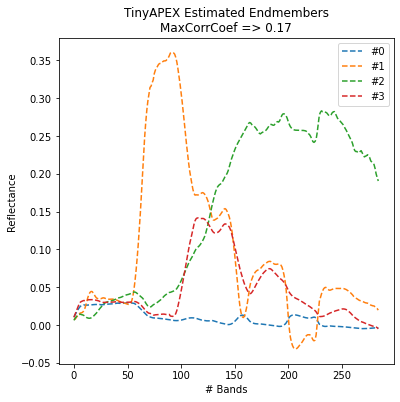

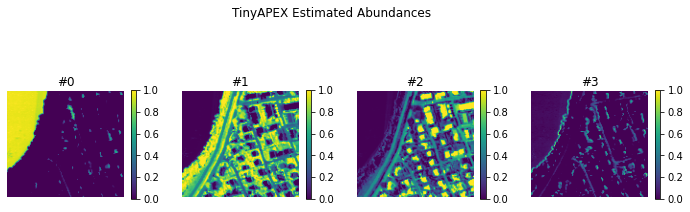

In [45]:

# Instantiate objects
extractor = VCA()
model = FCLSU()
hsi = HSI("TinyAPEX.mat")
    
# Endmembers extraction
E0 = extractor.init_like(hsi, seed=0)

# Call data to return HSI
Y, _, _ = hsi()

# Abundances estimation
A0 = model.solve(Y, E0)

# Plot results
hsi.plot_endmembers(E0=E0, display=True)
hsi.plot_abundances(A0=A0, display=True)

## Endmembers alignment

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.

In [39]:
class BaseMetric:
    def __init__(self):
        self.name = self.__class__.__name__

    @staticmethod
    def _check_input(X, Xref):
        assert X.shape == Xref.shape
        assert type(X) == type(Xref)
        return X, Xref

    def __call__(self, X, Xref):
        raise NotImplementedError

    def __repr__(self):
        return f"{self.name}"


class MeanAbsoluteError(BaseMetric):
    def __init__(self):
        super().__init__()

    def __call__(self, E, Eref):
        E, Eref = self._check_input(E, Eref)

        normE = LA.norm(E, axis=0, keepdims=True)
        normEref = LA.norm(Eref, axis=0, keepdims=True)

        return 100 * (1 - np.abs((E / normE).T @ (Eref / normEref)))


class SpectralAngleDistance(BaseMetric):
    def __init__(self):
        super().__init__()

    def __call__(self, E, Eref):
        E, Eref = self._check_input(E, Eref)

        normE = LA.norm(E, axis=0, keepdims=True)
        normEref = LA.norm(Eref, axis=0, keepdims=True)

        return np.arccos((E / normE).T @ (Eref / normEref))


class SADDegrees(SpectralAngleDistance):
    def __init__(self):
        super().__init__()

    def __call__(self, E, Eref):
        tmp = super().__call__(E, Eref)
        return (np.diag(tmp) * (180 / np.pi)).mean()


class MeanSquareError(BaseMetric):
    def __init__(self):
        super().__init__()

    def __call__(self, E, Eref):
        E, Eref = self._check_input(E, Eref)

        normE = LA.norm(E, axis=0, keepdims=True)
        normEref = LA.norm(Eref, axis=0, keepdims=True)

        return np.sqrt(normE.T ** 2 + normEref ** 2 - 2 * (E.T @ Eref))


class aRMSE(BaseMetric):
    def __init__(self):
        super().__init__()

    def __call__(self, A, Aref):
        A, Aref = self._check_input(A, Aref)
        return 100 * np.sqrt(((A - Aref) ** 2).mean())

In [41]:
class BaseAligner:
    def __init__(self, hsi, criterion):
        self.Eref = hsi.E
        self.criterion = criterion
        self.P = None
        self.dists = None

    def fit(self, E):
        raise NotImplementedError

    def transform(self, E):
        assert self.P is not None, "Must be fitted first"
        assert E.shape[1] == self.P.shape[0]
        assert E.shape[1] == self.P.shape[1]

        return E @ self.P

    def transform_abundances(self, A):
        assert self.P is not None, "Must be fitted first"
        assert A.shape[0] == self.P.shape[0]
        assert A.shape[0] == self.P.shape[1]

        return self.P.T @ A

    def fit_transform(self, E):

        self.fit(E)
        res = self.transform(E)

        return res

    def __repr__(self):
        msg = f"{self.__class__.__name__}_crit{self.criterion}"
        return msg

class GreedyAligner(BaseAligner):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, E):
        """
        Greedy alignment based on distances matrix using specified criterion

        Parameters:
            E: `numpy array`
                2D matrix of endmembers (L x p)

        Records:
            dists: `numpy array`
                2D distance matrix (p x p)

            P: `numpy array`
                2D permutation matrix (p x p)
            Permutes the columns to align the endmembers
            according to ground truth
        """
        self.dists = self.criterion(E, self.Eref)

        # Initialization
        d = np.copy(self.dists)
        p = E.shape[1]
        P = np.zeros((p, p))

        for _ in range(p):
            # Select argmin value
            idx = np.unravel_index(d.argmin(), d.shape)
            # Assign selection to permutation matrix
            P[idx] = 1.0
            # Render corresponding row/col unpickable
            d[idx[0]] = np.inf
            d[:, idx[1]] = np.inf

        self.P = P


class MunkresAligner(BaseAligner):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, E):
        """
        Alignment based on distances matrix using Hungarian Algorithm

        Parameters:
            E: `numpy array`
                2D matrix of endmembers (L x p)

        Records:
            dists: `numpy array`
                2D distance matrix between estimated and GT endmembers (p x p)

            P: `numpy array`
                2D permutation matrix (p x p)
            Permutes the columns to align the endmembers
            according to ground truth

        Source: https://software.clapper.org/munkres/
        """

        # Computing distance matrix
        self.dists = self.criterion(E, self.Eref)

        # Initialization
        p = E.shape[1]
        P = np.zeros((p, p))
        self.P = None

        m = Munkres()
        indexes = m.compute(self.dists)
        for row, col in indexes:
            P[row, col] = 1.0

        self.P = P

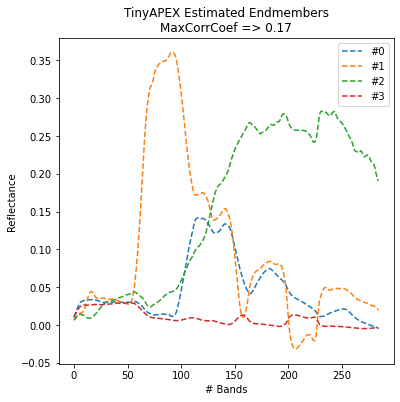

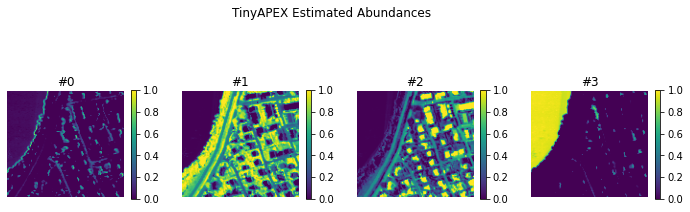

In [46]:
# Select a criterion to perform alignment
criterion = MeanAbsoluteError()

# Select an algorithm to perform alignment
aligner = MunkresAligner(hsi=hsi, criterion=criterion)

E1 = aligner.fit_transform(E0)
A1 = aligner.transform_abundances(A0)

# Plot alignment
hsi.plot_endmembers(E0=E1, display=True)
hsi.plot_abundances(A0=A1, display=True)

Notice how the materials were swapped.

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [51]:
# Instantiate metrics
rmse = aRMSE()
sad = SADDegrees()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")

RMSE => 16.15
SAD => 22.99
